In [13]:
# import required packages 
from gensim.models import Word2Vec, word2vec # word2vector model
import logging
import matplotlib.pyplot as plt
# for inline plot 
%matplotlib inline 
import nltk
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve #metrics
from sklearn.pipeline import Pipeline
import sqlite3
import re
from tqdm import tqdm
import os

# Summerises processing steps below
- Pre processing Data
    - Review Analysis : Identify Good/Bad Reviews
    - Create Training and Test datsets 
- Classification using Random Forest + word2vec
    - Traning word2vec model
    - Random Forest classifier using the word embedding information from word2vec model
    - Performance metrics for Random Forest + word2vec


## 1. Preprocessing Data

In [12]:
# Load the punkt tokenizer used for splitting reviews into sentences
# if you donot have the required NLTK model/data you can downlaod them using nltk.download() interface
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

### 1.1 Review Analysis : Identify Good/Bad Reviews

In [22]:
program_dir = os.getcwd()
data_folder = program_dir + "\database\database.sqlite"
#print(data_folder)
connection = sqlite3.connect(data_folder)
reviews = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", connection)
connection.close()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025A03B7FE48>]], dtype=object)

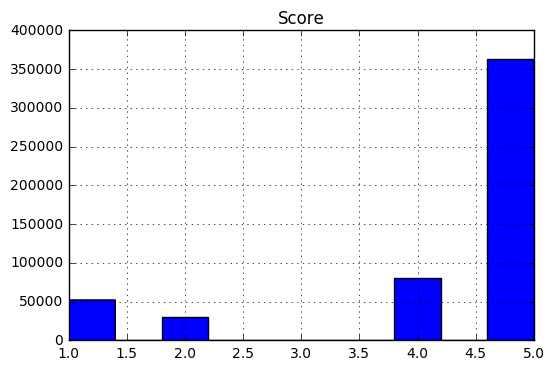

In [27]:
# Frequency distribution, histogram  
reviews.hist('Score')

In [26]:
#Review are heavily skewed towards the score of 5
reviews['Class'] = 1 * (reviews['Score'] > 3)
reviews.head(n=2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Class
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0


### 1.2 Create Training and Test datsets

In [28]:
reviews.sort_values('ProductId', axis=0, inplace=True)

train_size = int(len(reviews) * 0.5)
train_reviews = reviews.iloc[:train_size,:]
test_reviews = reviews.iloc[train_size:,:]

test_remove = np.logical_or(test_reviews['ProductId'].isin(train_reviews['ProductId']),
                          test_reviews['UserId'].isin(train_reviews['UserId']))
test_reviews = test_reviews[np.logical_not(test_remove)]

In [29]:
# Print and verify the dataset deatils before proceeding further
print('Training set contains {:d} reviews.'.format(len(train_reviews)))
print('Test set contains {:d} reviews ({:d} removed).'.format(len(test_reviews), sum(test_remove)))

n_pos_train = sum(train_reviews['Class'] == 1)
print('Training set contains {:.2%} positive reviews'.format(n_pos_train/len(train_reviews)))
n_pos_test = sum(test_reviews['Class'] == 1)
print('Test set contains {:.2%} positive reviews'.format(n_pos_test/len(test_reviews)))

Training set contains 262907 reviews.
Test set contains 151198 reviews (111709 removed).
Training set contains 84.93% positive reviews
Test set contains 82.37% positive reviews


Convert each review in the training set to a list of sentences where each sentence is in turn a list of words. Besides splitting reviews into sentences, non-letters and (optionally) stop words are removed and all words coverted to lower case.

In [31]:
def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    """
    Split review into list of sentences where each sentence is a list of words.
    Removal of stop words is optional.
    """
    # use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    # each sentence is furthermore split into words
    sentences = []    
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
            
    return sentences

In [32]:
train_sentences = []  # Initialize an empty list of sentences
for review in train_reviews['Text']:
    train_sentences += review_to_sentences(review, tokenizer)

## 3. Classification using Random Forest + word2vec

### 3.1 Traning word2vec model

In [65]:
model_name = 'train_model'
# Set values for various word2vec parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words
if not os.path.exists(model_name): 
    # Initialize and train the model (this will take some time)
    model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
else:
    model = Word2Vec.load(model_name)

In [61]:
model.wv.similar_by_vector(model['house'] - model['kitchen'])

C:\Users\jxp161430\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


[('house', 0.4771435856819153),
 ('intervals', 0.3224315643310547),
 ('choo', 0.2692919969558716),
 ('weimaraner', 0.2502148151397705),
 ('least', 0.2496238499879837),
 ('office', 0.24764585494995117),
 ('petco', 0.24654215574264526),
 ('gerd', 0.24327412247657776),
 ('target', 0.2423928827047348),
 ('costco', 0.23867826163768768)]

In [62]:
model.wv.most_similar("awesome")

[('amazing', 0.8036275506019592),
 ('incredible', 0.7612615823745728),
 ('unbelievable', 0.7226647138595581),
 ('fantastic', 0.7217581272125244),
 ('excellent', 0.7166696786880493),
 ('outstanding', 0.7064791917800903),
 ('terrific', 0.6885495185852051),
 ('great', 0.6701348423957825),
 ('fabulous', 0.6433342695236206),
 ('exceptional', 0.6241912841796875)]

In [63]:
model.wv.most_similar("worse")

[('better', 0.612735390663147),
 ('smarter', 0.5568113327026367),
 ('nicer', 0.5255180597305298),
 ('tougher', 0.5231730937957764),
 ('hotter', 0.5183761119842529),
 ('tastier', 0.5133669972419739),
 ('weaker', 0.4961473345756531),
 ('dryer', 0.4956180453300476),
 ('sweeter', 0.4921164810657501),
 ('quicker', 0.49098289012908936)]

In [64]:
#classic example for word embedding always
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('charles', 0.5089073777198792),
 ('cavalier', 0.4717809557914734),
 ('arthur', 0.43065279722213745),
 ('cocker', 0.4269113540649414),
 ('springer', 0.4194915294647217),
 ('spaniel', 0.41420602798461914),
 ('german', 0.3898002505302429),
 ('breeder', 0.3746984004974365),
 ('spaniels', 0.374674916267395),
 ('greyhound', 0.37258338928222656)]

### 3.2 Random Forest classifier using the word embedding information from word2vec model

Feature vector  for Random Forest classifier = avg(word embeddings of all words in the review)


In [48]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs

# calculate average feature vectors for training and test sets
clean_train_reviews = []
for review in train_reviews['Text']:
    clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)

clean_test_reviews = []
for review in test_reviews['Text']:
    clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))
testDataVecs = get_avg_feature_vecs(clean_test_reviews, model, num_features)

C:\Users\jxp161430\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\jxp161430\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\jxp161430\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


In [49]:
# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(trainDataVecs, train_reviews['Class'])

Fitting a random forest to labeled training data...


In [50]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x,y in np.argwhere(np.isnan(testDataVecs))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    testDataVecs = np.delete(testDataVecs, nan_indices, axis=0)
    test_reviews.drop(test_reviews.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert testDataVecs.shape[0] == len(test_reviews)

Removing 1 instances from test set.


### 3.3 Performance metrics for Random Forest + word2vec

In [51]:
print("Predicting labels for test data..")
result = forest.predict(testDataVecs)

probs = forest.predict_proba(testDataVecs)[:, 1]

fpr, tpr, _ = roc_curve(test_reviews['Class'], probs)
auc = roc_auc_score(test_reviews['Class'], probs)

Predicting labels for test data..
